<a href="https://colab.research.google.com/github/fmahboub/Replicating-Burgstahler-and-Dichev-1997-/blob/master/Burgstahler_and_Dichev_1997.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install wrds

     |████████████████████████████████| 2.9MB 6.3MB/s 


In [0]:
# Reference: Burgstahler and Dichev (1997)

import pandas as pd
import wrds
import matplotlib.pyplot as plt
conn = wrds.Connection()

import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

Enter your WRDS username [root]:faran2
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [0]:
# 1. Sample selection
funda = conn.raw_sql("""
                      select gvkey, fyear, ni, csho, prcc_f, sich
	                  from compa.funda where
	                   (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                       fyear<1995 and
                       fyear>1973
                      """) 
company = conn.raw_sql("""
                      select gvkey, sic
	                  from compa.company
                     """) 

funda1=pd.merge(funda,company,on=['gvkey'])
funda1['sic1']=np.where(funda1['sich']>0,funda1['sich'],funda1['sic'])
funda1=funda1.drop(['sich','sic'],axis=1)
funda1['sic1']=funda1['sic1'].astype(int)

# industry restriction
indexNames =funda1[ (funda1['sic1'] >= 4400) & (funda1['sic1'] <= 5000) ].index
funda1.drop(indexNames , inplace=True)
indexNames =funda1[ (funda1['sic1'] >= 6000) & (funda1['sic1'] <= 6500) ].index
funda1.drop(indexNames , inplace=True)


# 2. Variable construction
funda1.describe()
funda1['mv']=funda1['csho']*funda1['prcc_f']
# Note: mkvalt is not complete. Units for Ni: million, csho: million, 

# generate lag variables
funda1_lag1= funda1[['gvkey','fyear','ni','mv']].copy() 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'earn_lag1'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

funda1_lag1= funda1[['gvkey','fyear','mv_lag1']].copy() 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv_lag1':'mv_lag2'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

# generate test variables
funda1=funda1.rename(columns={'ni':'earn'})

funda1['earnchg'] = funda1['earn'] - funda1['earn_lag1']

# scale earn with mv_lag1 and earnchg with mv_lag2
funda1=funda1.dropna()
funda1

,gvkey,fyear,earn,csho,prcc_f,sic1,mv,earn_lag1,mv_lag1,mv_lag2,earnchg
2,001000,1976.0,3.434,2.207,5.750,3089,12.690250,2.284,9.178750,4.568750,1.150
3,001000,1977.0,1.928,2.226,9.250,3089,20.590500,3.434,12.690250,9.178750,-1.506
11,001001,1985.0,2.576,3.988,10.125,5812,40.378500,1.138,13.380000,25.868000,1.438
17,001003,1985.0,0.236,2.683,4.500,5712,12.073500,0.387,7.378250,14.085750,-0.151
18,001003,1986.0,0.793,2.683,4.500,5712,12.073500,0.236,12.073500,7.378250,0.557
...,...,...,...,...,...,...,...,...,...,...,...
142092,153954,1988.0,3.498,36.657,2.000,1311,73.314000,4.199,82.539789,67.737595,-0.701
142093,153954,1989.0,3.446,36.657,2.891,1311,105.975379,3.498,73.314000,82.539789,-0.052
142094,153954,1990.0,2.912,36.657,2.547,1311,93.365376,3.446,105.975379,73.314000,-0.534
142095,153954,1991.0,-9.710,36.657,2.344,1311,85.924003,2.912,93.365376,105.975379,-12.622


In [0]:
# winsorize before doing scales.
varlist=['earn','mv_lag1','mv_lag2','earn_lag1']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

# Do scales
funda1['earn_s']=funda1['earn']/funda1['mv_lag1']
funda1['earnchg_s'] = funda1['earnchg']/funda1['mv_lag2']

In [0]:
funda3=funda1[['gvkey','fyear','earn_s']]
# winsorize again for the scaled variables. 
funda2=funda3.dropna()
funda2.describe()

varlist=['earn_s']
for var in varlist:
    funda2[var] = funda2[var].replace(np.Inf, np.nan)
    funda2[var]=np.where(funda2[var].isnull(), np.nan, winsorize(funda2[var], limits=(0.01,0.01)))

In [0]:
# Table 1 (Panel B)
destable=funda2.describe().transpose()  # pooled sample
desearn_s=funda2.groupby('fyear')['earn_s'].describe() # Table 1 Panel B
desearn_s = desearn_s.round(decimals=2)
desearn_s = desearn_s.drop(desearn_s.columns[[3, 7]], axis=1)
print("-------------- Table 1 Panel B -------------")
print(desearn_s)

-------------- Table 1 Panel B -------------
         count  mean   std   25%   50%   75%
fyear                                       
1976.0  3019.0  0.13  0.34  0.08  0.16  0.25
1977.0  2942.0  0.11  0.29  0.08  0.14  0.21
1978.0  2849.0  0.14  0.26  0.10  0.16  0.23
1979.0  2790.0  0.13  0.26  0.09  0.16  0.23
1980.0  2978.0  0.09  0.31  0.07  0.13  0.19
1981.0  3243.0  0.07  0.28  0.03  0.10  0.17
1982.0  3389.0  0.01  0.32 -0.01  0.07  0.14
1983.0  3853.0  0.01  0.34 -0.03  0.07  0.13
1984.0  3931.0  0.01  0.27 -0.02  0.06  0.11
1985.0  4102.0 -0.04  0.35 -0.06  0.05  0.10
1986.0  4125.0 -0.05  0.35 -0.07  0.04  0.09
1987.0  4104.0 -0.03  0.31 -0.05  0.05  0.09
1988.0  4176.0 -0.03  0.34 -0.06  0.05  0.10
1989.0  4368.0 -0.05  0.34 -0.08  0.04  0.10
1990.0  4314.0 -0.08  0.38 -0.09  0.03  0.08
1991.0  4307.0 -0.12  0.46 -0.13  0.03  0.09
1992.0  4322.0 -0.07  0.39 -0.08  0.03  0.08
1993.0  4387.0 -0.04  0.34 -0.06  0.04  0.08
1994.0  4595.0 -0.02  0.27 -0.03  0.05  0.08


In [0]:
funda4=funda1[['gvkey','fyear','earnchg_s']]
# winsorize again for the scaled variables. 
funda5=funda4.dropna()
funda5.describe()

varlist=['earnchg_s']
for var in varlist:
    funda5[var] = funda5[var].replace(np.Inf, np.nan)
    funda5[var]=np.where(funda5[var].isnull(), np.nan, winsorize(funda5[var], limits=(0.03,0.03)))

In [0]:
# Table 1 (Panel A)
destable=funda5.describe().transpose()  # pooled sample
desearn_s=funda5.groupby('fyear')['earnchg_s'].describe() # Table 1 Panel A
desearn_s = desearn_s.round(decimals=2)
desearn_s = desearn_s.drop(desearn_s.columns[[3, 7]], axis=1)
print("-------------- Table 1 Panel A -------------")
print(desearn_s)

-------------- Table 1 Panel A -------------
         count  mean   std   25%   50%   75%
fyear                                       
1976.0  3019.0  0.07  0.25 -0.00  0.05  0.15
1977.0  2942.0  0.04  0.21 -0.02  0.03  0.09
1978.0  2849.0  0.06  0.19  0.00  0.03  0.09
1979.0  2790.0  0.03  0.20 -0.02  0.03  0.08
1980.0  2978.0 -0.00  0.21 -0.05  0.01  0.06
1981.0  3243.0  0.01  0.21 -0.04  0.01  0.07
1982.0  3389.0 -0.02  0.20 -0.08 -0.01  0.03
1983.0  3853.0  0.03  0.21 -0.04  0.02  0.08
1984.0  3931.0  0.02  0.22 -0.04  0.01  0.07
1985.0  4102.0 -0.01  0.18 -0.06 -0.00  0.03
1986.0  4125.0  0.01  0.23 -0.06  0.00  0.06
1987.0  4104.0  0.03  0.22 -0.03  0.01  0.08
1988.0  4176.0  0.01  0.20 -0.03  0.01  0.06
1989.0  4368.0 -0.00  0.22 -0.06  0.00  0.05
1990.0  4314.0 -0.01  0.22 -0.07  0.00  0.05
1991.0  4307.0 -0.00  0.22 -0.07  0.00  0.05
1992.0  4322.0  0.02  0.26 -0.06  0.01  0.09
1993.0  4387.0  0.02  0.23 -0.04  0.01  0.07
1994.0  4595.0  0.03  0.22 -0.03  0.02  0.07


<function matplotlib.pyplot.show>

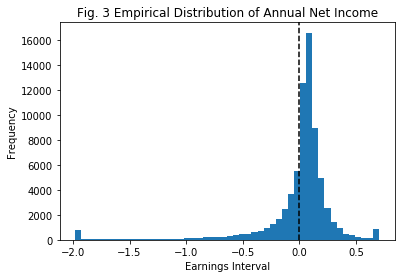

In [0]:
# Figure 3

plt.hist(funda2['earn_s'], bins=50)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig. 3 Empirical Distribution of Annual Net Income')
plt.show

<function matplotlib.pyplot.show>

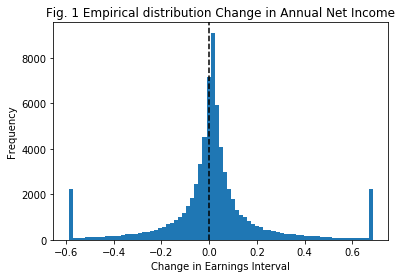

In [0]:
# Figure 1

plt.hist(funda5['earnchg_s'], bins=75)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Change in Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig. 1 Empirical distribution Change in Annual Net Income')
plt.show